# Real or Not? NLP with Disaster Tweets

In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
!jt -l
!jt -t onedork -ofs 10 -dfs 9 -nfs 11 -tfs 11
jtplot.style(theme = 'onedork', fscale = 1.4 , context = 'notebook', ticks = True, 
             grid = False)

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from itertools import islice, izip
from sklearn.pipeline import Pipeline
from sklearn import metrics
from matplotlib import pylab as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from collections import defaultdict, Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import string 
import seaborn as sns
import re

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Загрузим датасеты
data_train = pd.read_csv('train_nlp.csv', sep = ',', encoding = 'utf-8')
data_test = pd.read_csv('test_nlp.csv', sep = ',', encoding = 'utf-8')

In [5]:
data_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data_train.shape

(7613, 5)

# EDA

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 208.2+ KB


Выборка вплоне сбалансированная, примерно одинаковое количество твитов с катастрофой и остальных твитов.

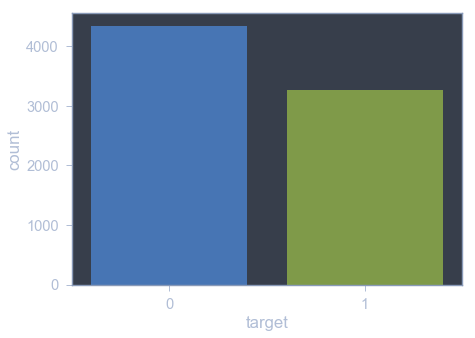

In [8]:
plt.figure(figsize = (7, 5))
sns.countplot(data_train['target'])
plt.show()

In [9]:
#Разделим твиты с катастрофами и остальные твиты
dis_tweet = data_train['text'][data_train['target'] == 1]
notdis_tweet = data_train['text'][data_train['target'] == 0]

Проанализируем распределение количества слов в твитах в обеих группах

 - Существенной разницы в длинне твитов не наблюдается.

In [10]:
dis_len = dis_tweet.str.split().map(lambda x: len(x))
notdis_len = notdis_tweet.str.split().map(lambda x: len(x))

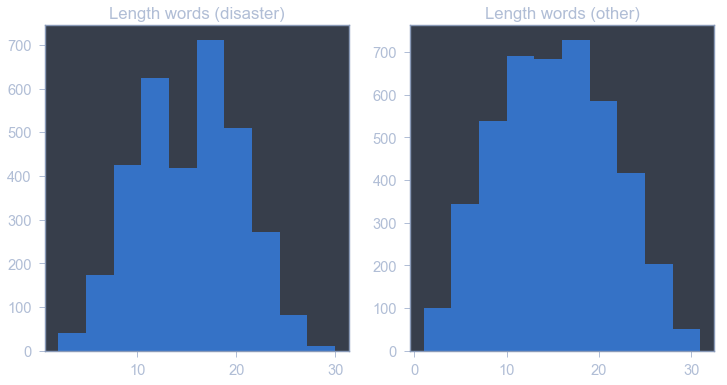

In [11]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.hist(dis_len)
plt.title('Length words (disaster)')

plt.subplot(1, 2, 2)
plt.hist(notdis_len)
plt.title('Length words (other)')
plt.show()

Количество твитов в зависимости от категории при указанных|неуказанных локациях

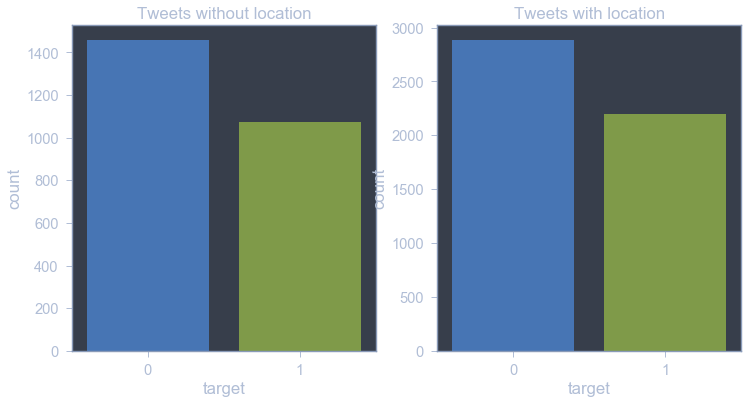

In [12]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data_train['target'][data_train['location'].isnull()])
plt.title(u'Tweets without location')

plt.subplot(1, 2, 2)
sns.countplot(data_train['target'][data_train['location'].notnull()])
plt.title(u'Tweets with location')
plt.show()

In [13]:
top_keyword_dis = data_train[data_train['target'] == 1]['keyword'].value_counts()[:10]
top_keyword_notdis = data_train[data_train['target'] == 0]['keyword'].value_counts()[:10]

In [14]:
print 'Top 10 keywords with disaster \n', top_keyword_dis
print '\n'
print 'Top 10 keywords other tweets \n', top_keyword_notdis

Top 10 keywords with disaster 
derailment           39
outbreak             39
wreckage             39
debris               37
oil%20spill          37
typhoon              37
suicide%20bombing    32
suicide%20bomb       32
rescuers             32
evacuated            32
Name: keyword, dtype: int64


Top 10 keywords other tweets 
body%20bags    40
armageddon     37
harm           37
deluge         36
ruin           36
wrecked        36
twister        35
siren          35
fear           35
explode        35
Name: keyword, dtype: int64


Количество твитов в зависимости от категории при указанных|неуказанных ключевых словах

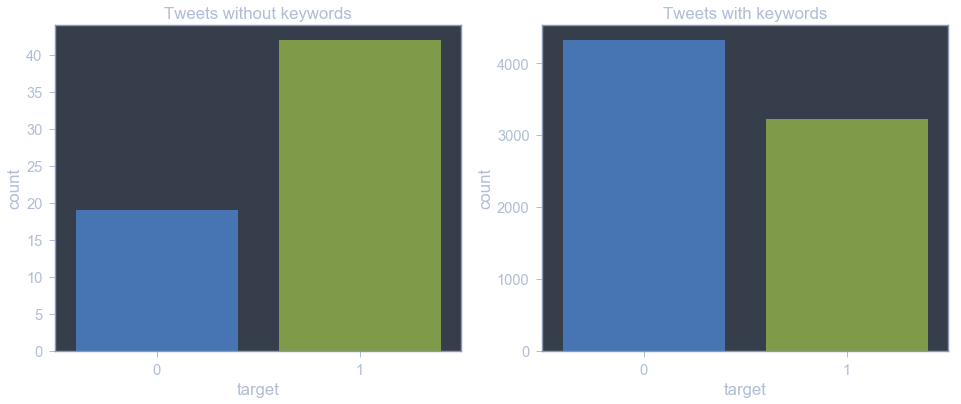

In [15]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
sns.countplot(data_train['target'][data_train['keyword'].isnull()])
plt.title(u'Tweets without keywords')

plt.subplot(1, 2, 2)
sns.countplot(data_train['target'][data_train['keyword'].notnull()])
plt.title(u'Tweets with keywords')
plt.show()

Проанализируем частоты n-gram в твитах

In [16]:
#Приведем к нижнему регистру
data_train['text'] = data_train['text'].apply(lambda x: x.lower())

In [17]:
def join_text(text):
    combined_text = ' '.join(text)
    return combined_text

In [18]:
#N-gram values function
def count_grams(data, n_min, n_max):
    vectorizer_unogram = CountVectorizer(ngram_range = (n_min, n_max))
    X = vectorizer_unogram.fit_transform(data)
    unograms = np.ravel(X.sum(axis = 0))
    count_word = []
    for count, uno in zip(unograms, vectorizer_unogram.get_feature_names()):
        count_word.append((count, uno))
    count_word.sort()
    count_word = pd.DataFrame(count_word[-20:], columns = ['count', 'grams'])
    count_word.sort_values(by = 'count', ascending = False, inplace = True)
    return count_word

In [19]:
unograms = count_grams(data_train['text'], 1, 1)
bigrams = count_grams(data_train['text'], 2, 2)

20 самых часто встречаемых унограмм и биграмм

 - Чаще всего встречаются ссылки или стоп слова, которые необходимо убрать из твитов

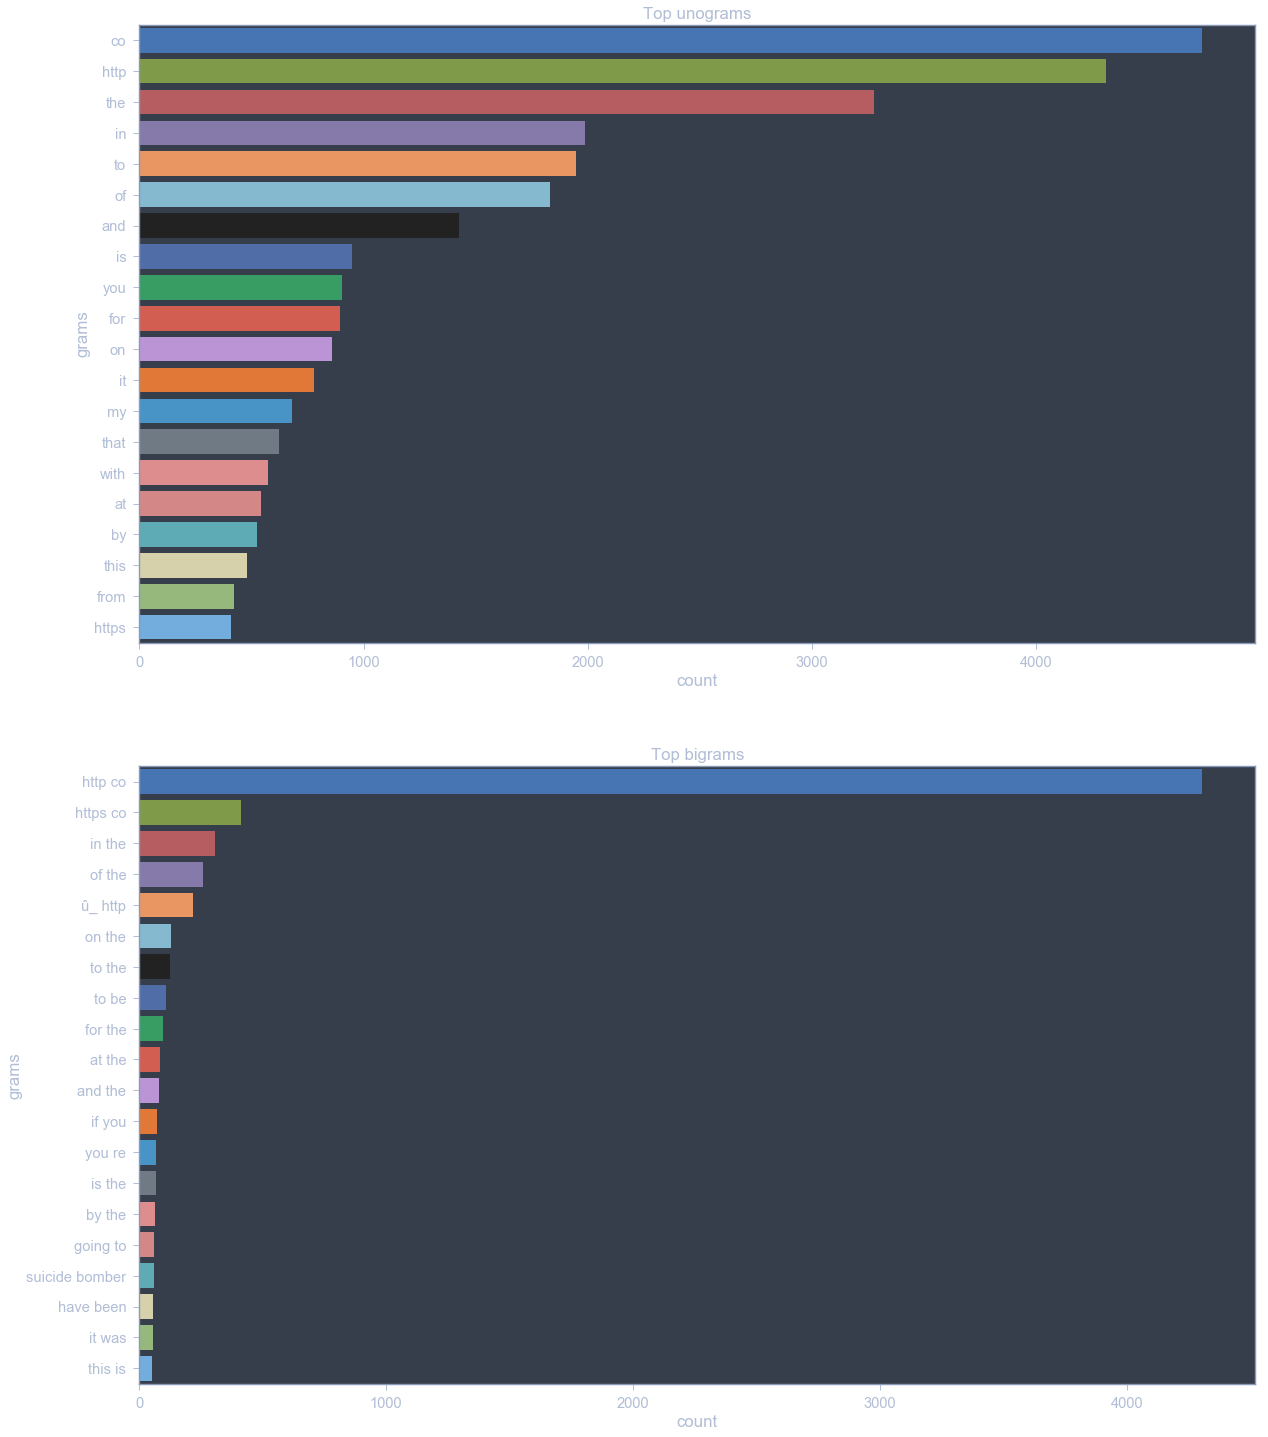

In [20]:
plt.figure(figsize = (20, 25))

plt.subplot(2, 1, 1)
sns.barplot(x = unograms['count'], y = unograms['grams'])
plt.title(u'Top unograms')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams['count'], y = bigrams['grams'])
plt.title(u'Top bigrams')

plt.show()

Проанализируем те же частоты, но в зависимости от группы

In [21]:
#unograms
dis_unograms = count_grams(data_train[data_train['target'] == 1]['text'], 1, 1)
notdis_unograms = count_grams(data_train[data_train['target'] == 0]['text'], 1, 1)

#bigrams
dis_bigrams = count_grams(data_train[data_train['target'] == 1]['text'], 2, 2)
notdis_bigrams = count_grams(data_train[data_train['target'] == 0]['text'], 2, 2)

 - Частоты слов для двух групп практически не отличаются 
 - В топе находятся стоп слова и разные ссылки, которые не несут полезной информации, а только добавляют шум

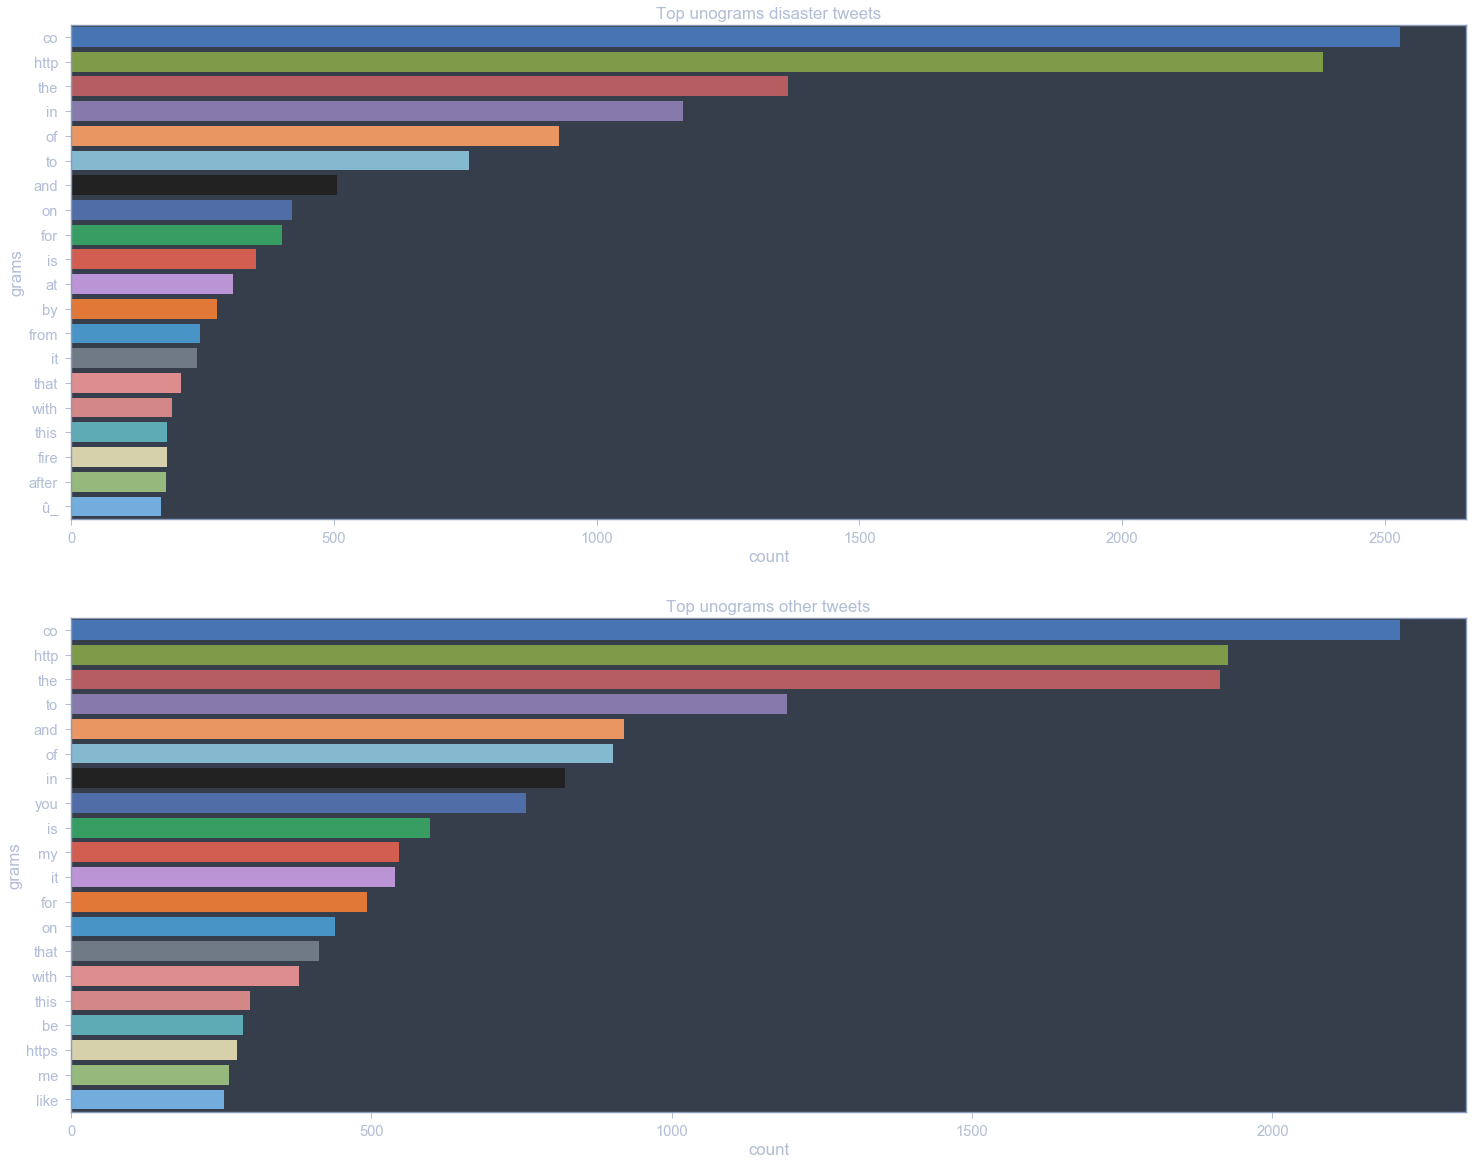

In [22]:
plt.figure(figsize = (25, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = dis_unograms['count'], y = dis_unograms['grams'])
plt.title(u'Top unograms disaster tweets')

plt.subplot(2, 1, 2)
sns.barplot(x = notdis_unograms['count'], y = notdis_unograms['grams'])
plt.title(u'Top unograms other tweets')

plt.show()

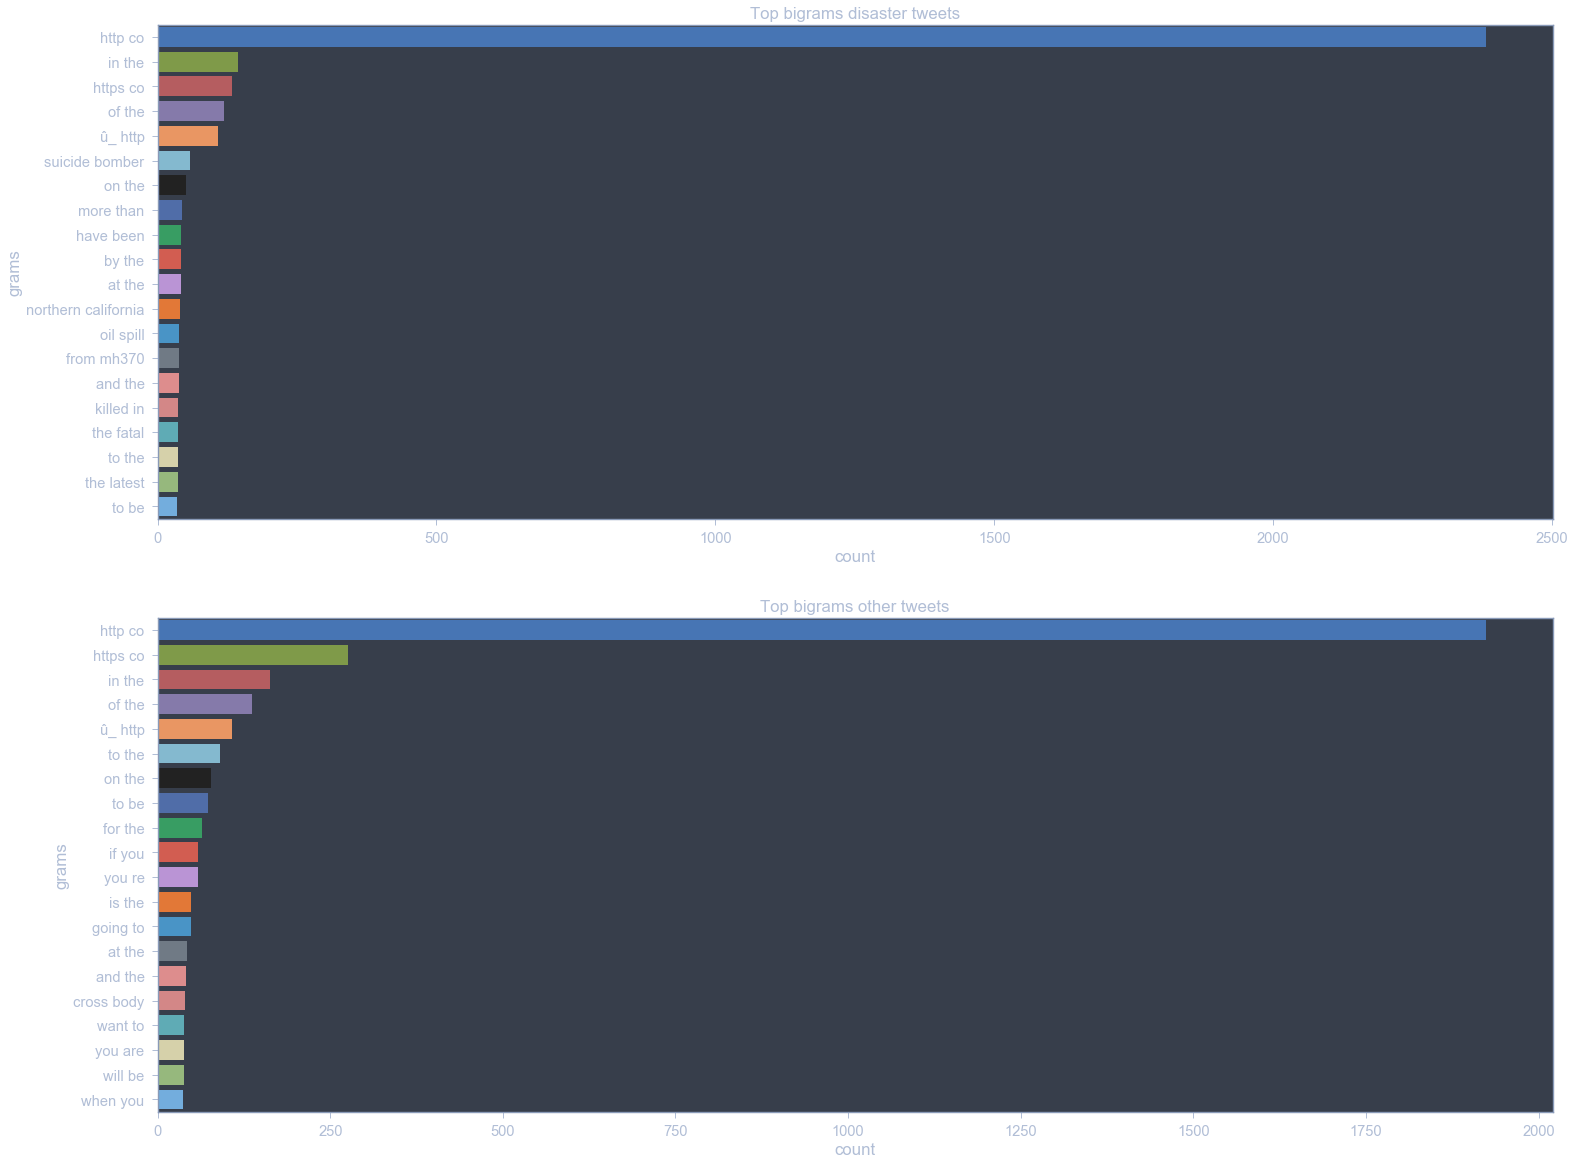

In [23]:
plt.figure(figsize = (25, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = dis_bigrams['count'], y = dis_bigrams['grams'])
plt.title(u'Top bigrams disaster tweets')

plt.subplot(2, 1, 2)
sns.barplot(x = notdis_bigrams['count'], y = notdis_bigrams['grams'])
plt.title(u'Top bigrams other tweets')

plt.show()

- Средняя длина слов в твитах в зависимости от группы

In [24]:
#mean length words (disaster tweets)
word_dis = data_train[data_train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
dis_mean = word_dis.map(lambda x: np.mean(x))

#mean length words (other tweets)
word_notdis = data_train[data_train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
notdis_mean = word_notdis.map(lambda x: np.mean(x))

Существенных различий в распределениях средней длинны слов в обеих группах не наблюдается

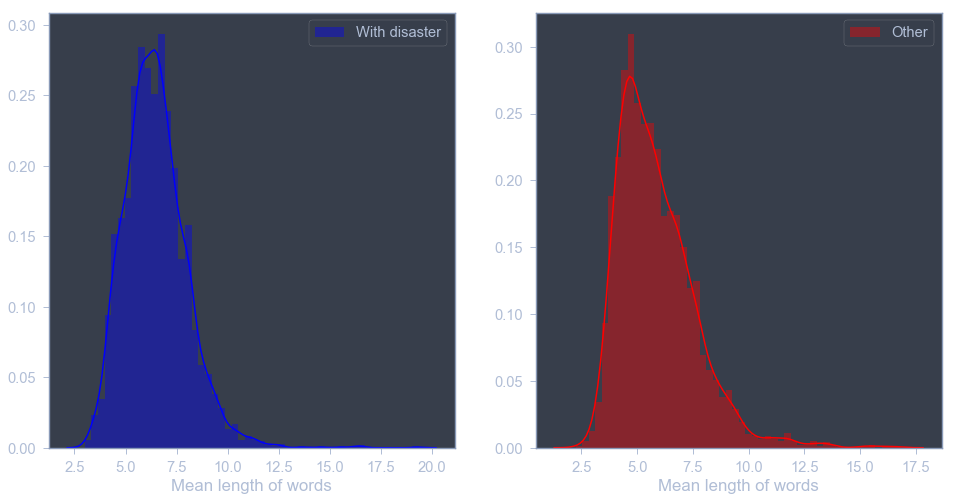

In [25]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
sns.distplot(dis_mean, color = 'blue', label = 'With disaster')
plt.xlabel('Mean length of words')
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(notdis_mean, color = 'red', label = 'Other')
plt.xlabel('Mean length of words')
plt.legend()
plt.show()

Проанализируем пунктуацию и прочие символы

In [26]:
def corpus(data):
    dict_word = []
    for sentences in data:
        for word in sentences:
            dict_word.append(word)
    return dict_word

In [27]:
#Знаки пунктуации
punctuations = string.punctuation

#Создадим словарь знаков
tokens = data_train['text'].apply(nltk.word_tokenize)
punct = tokens.apply(lambda x: [i for i in x if i in punctuations])
tokens_punct = corpus(punct)

In [28]:
#Посчитаем их количество
diction = defaultdict(int)
for i in tokens_punct:
    diction[i] += 1
x, y = (zip(*diction.items()))

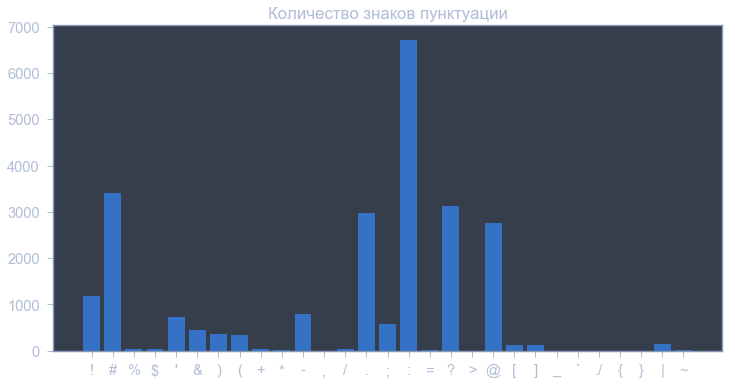

In [29]:
plt.figure(figsize = (12, 6))
plt.bar(x, y)
plt.title(u'Количество знаков пунктуации')
plt.show()

# Text preprocessing

In [30]:
all_data = pd.concat([data_train, data_test], ignore_index = True)
all_data.head(5)

D:\Python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,id,keyword,location,target,text
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...


In [31]:
#Приведем к нижнему регистру
all_data['text'] = all_data['text'].apply(lambda x: x.lower())

#Удалим url ссылки
all_data['text1'] = all_data['text'].apply(lambda x: re.sub('https?://\S+|www\.\S+', '', x))

#Удалим хештеги
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub('#', '', x))

#Удалим отметки пользователей
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub('@', '', x))

#Удалим html теги
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub(r'<.*?>', '', x))

#
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", x))

#Уберем пробелы
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub('\n', '', x))

#
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub('\w*\d\w*', '', x))

#Удалим amp
all_data['text1'] = all_data['text1'].apply(lambda x: re.sub(r'amp', '', x))

In [32]:
all_data.head(5)

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,forest fire near la ronge sask canada
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",", people receive wildfires evacuation orders i..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as s...


Разобъем текст на токены

In [33]:
all_data['text1'] = all_data['text1'].apply(nltk.word_tokenize)
all_data.head(5)

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,"[all, residents, asked, to, 'shelter, in, plac..."
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...","[,, people, receive, wildfires, evacuation, or..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,"[just, got, sent, this, photo, from, ruby, ala..."


Удалим стоп слова

In [34]:
#Словарь стоп-слов
stop_words = stopwords.words('english')

#Удалим стоп слова
all_data['text1'] = all_data['text1'].apply(lambda x: [i for i in x if i not in stop_words])
all_data.head(5)

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,"[residents, asked, 'shelter, place, ', notifie..."
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...","[,, people, receive, wildfires, evacuation, or..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


Удалим пунктуацию и прочие символы

In [35]:
all_data['text1'] = all_data['text1'].apply(lambda word: [i for i in word if i.isalpha()])
all_data.head(5)

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,"[residents, asked, place, notified, officers, ..."
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [36]:
#Соберем предложения обратно
all_data['text1'] = all_data['text1'].apply(lambda x: join_text(x))
all_data.head(5)

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,forest fire near la ronge sask canada
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,residents asked place notified officers evacua...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,got sent photo ruby alaska smoke wildfires pou...


Частоты слов после очистки твитов от шума

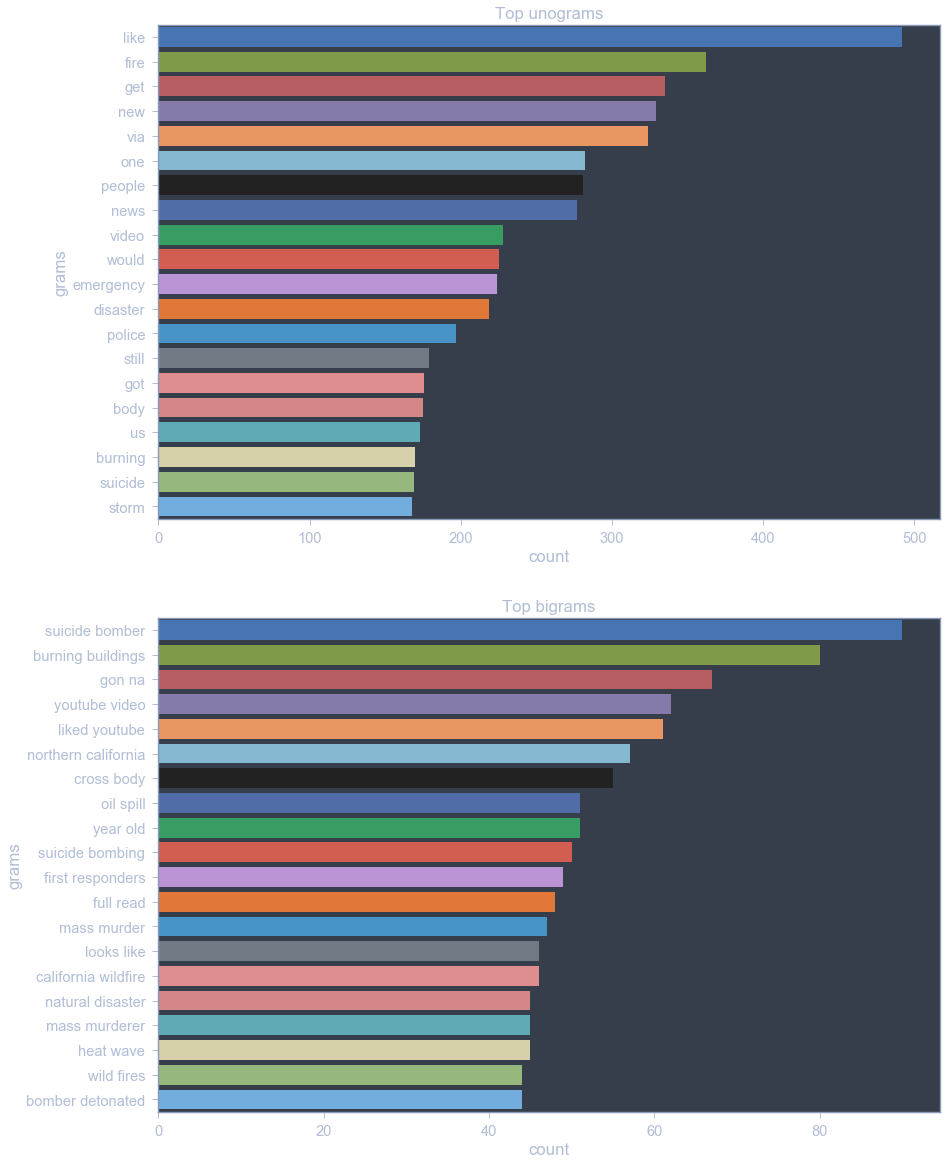

In [37]:
unograms = count_grams(all_data['text1'], 1, 1)
bigrams = count_grams(all_data['text1'], 2, 2)

plt.figure(figsize = (14, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = unograms['count'], y = unograms['grams'])
plt.title(u'Top unograms')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams['count'], y = bigrams['grams'])
plt.title(u'Top bigrams')

plt.show()

Рассмотрим частоты в зависимости от типа твитов

 - После очистки текста появились существенные различия частот слов в обеих группах

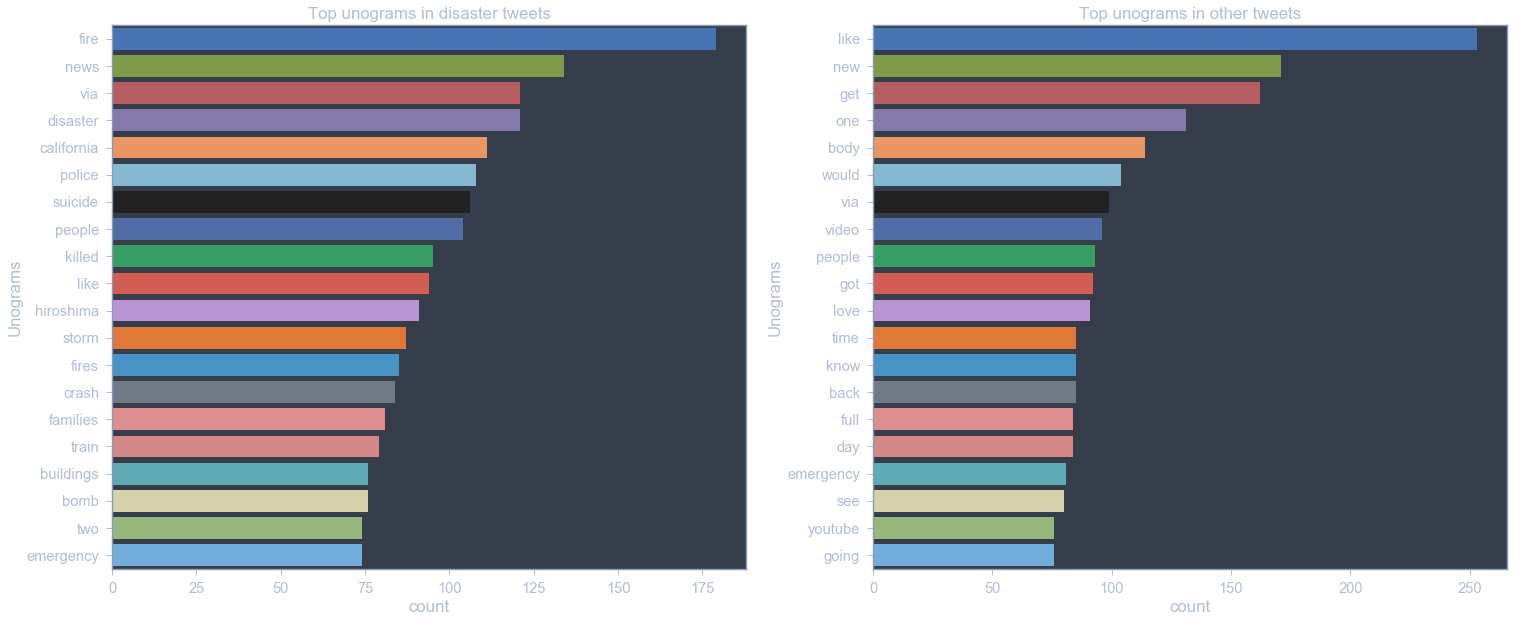

In [38]:
unograms_dis = count_grams(all_data[all_data['target'] == 1]['text1'], 1, 1)
unograms_notdis = count_grams(all_data[all_data['target'] == 0]['text1'], 1, 1)

plt.figure(figsize = (25, 10))

plt.subplot(1, 2, 1)
sns.barplot(x = unograms_dis['count'], y = unograms_dis['grams'])
plt.title(u'Top unograms in disaster tweets')
plt.ylabel('Unograms')

plt.subplot(1, 2, 2)
sns.barplot(x = unograms_notdis['count'], y = unograms_notdis['grams'])
plt.title(u'Top unograms in other tweets')
plt.ylabel('Unograms')

plt.show()

 - В твитах с катастрофами преобладают биграммы, сообщающие о какой-либо катастрофе 
 - В твитах без катастроф наблюдаются более общие словосочетания

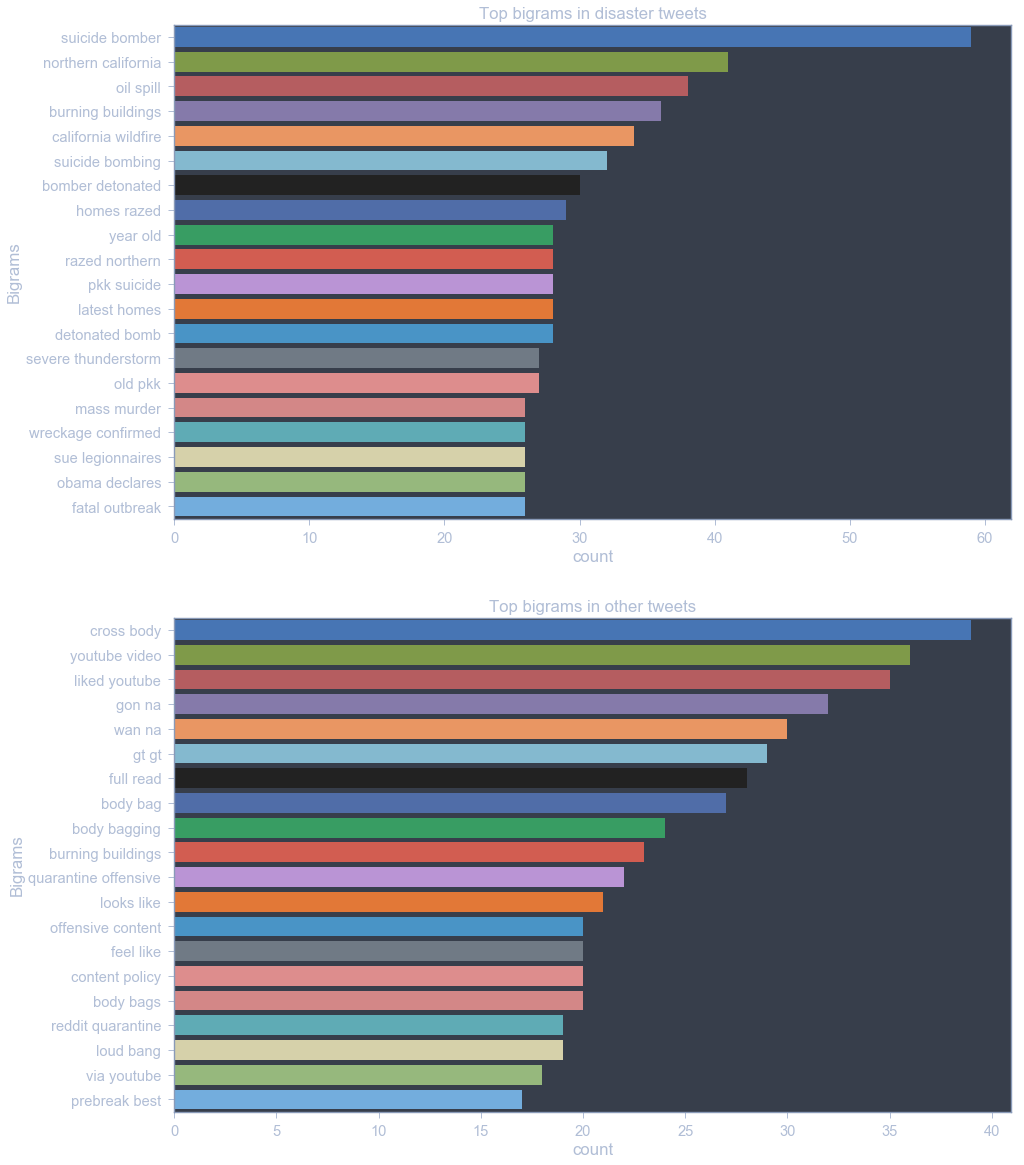

In [39]:
bigrams_dis = count_grams(all_data[all_data['target'] == 1]['text1'], 2, 2)
bigrams_notdis = count_grams(all_data[all_data['target'] == 0]['text1'], 2, 2)

plt.figure(figsize = (15, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = bigrams_dis['count'], y = bigrams_dis['grams'])
plt.title(u'Top bigrams in disaster tweets')
plt.ylabel('Bigrams')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams_notdis['count'], y = bigrams_notdis['grams'])
plt.title(u'Top bigrams in other tweets')
plt.ylabel('Bigrams')

plt.show()

Приведем слова к одинаковой форме

- Существует 2 основных подхода:

  - Лемматизация - приведение слов к одной форме по правилам и словарю

  - Стемминг - отрезает "лишнее" окончание (часто итоговые слова получаются неправильные)

In [40]:
#improt stemmer, lemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
#Разобьем текст на токены
all_data['text1'] = all_data['text1'].apply(nltk.word_tokenize)

#Lemmatizer
Lemmatizer = WordNetLemmatizer()

#Stemmer
Stemmer = PorterStemmer()

#Lemmatize and Stem преобразования
all_data['lemma'] = all_data['text1'].apply(lambda x: [Lemmatizer.lemmatize(i) for i in x])
all_data['stemm'] = all_data['text1'].apply(lambda x: [Stemmer.stem(i) for i in x])

all_data.head(5)

,id,keyword,location,target,text,text1,lemma,stemm
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,"[residents, asked, place, notified, officers, ...","[resident, asked, place, notified, officer, ev...","[resid, ask, place, notifi, offic, evacu, shel..."
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,...","[peopl, receiv, wildfir, evacu, order, califor..."
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [42]:
#Соберем предложения обратно
all_data['lemma'] = all_data['lemma'].apply(lambda x: join_text(x))
all_data['stemm'] = all_data['stemm'].apply(lambda x: join_text(x))

#train|test
data_train = all_data.iloc[:len(data_train)]
data_test = all_data.iloc[len(data_train):]
data_test.drop(columns = 'target', axis = 1, inplace = True)

#Выделим целевую переменную
target = data_train['target'].values
all_data.head(5)

D:\Python\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,id,keyword,location,target,text,text1,lemma,stemm
0,1,NaN,NaN,1.0,our deeds are the reason of this #earthquake m...,"[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,1.0,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,forest fire near la rong sask canada
2,5,NaN,NaN,1.0,all residents asked to 'shelter in place' are ...,"[residents, asked, place, notified, officers, ...",resident asked place notified officer evacuati...,resid ask place notifi offic evacu shelter pla...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order...",people receive wildfire evacuation order calif...,peopl receiv wildfir evacu order california
4,7,NaN,NaN,1.0,just got sent this photo from ruby #alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,got sent photo rubi alaska smoke wildfir pour ...


# PCA

Сущестсвует 2 основных способа представления текстов:

 -  TfidfVectorizer (позволяет оценивать важность слов в предложении). Если слово встречается в данном документе часто, а в остальных редко --> это слово важно для данного документа и оно будет иметь большой вес
 -  CountVectorizer. Просто частоты слов в предложении

Понизим размерность и оценим разделимость классов

1. CountVectorizer + Stemmer
2. CountVectorizer + Lemma
3. TfidfVectorizer + Stemmer
4. TfidfVectorizer + Lemma

Визуально наиболее разделимой выборкой явлется случай TfidfVectorizer + Lemma

In [43]:
pca = TruncatedSVD()
count_vect = CountVectorizer(ngram_range = (1, 3))
tfidf_vect = TfidfVectorizer(ngram_range = (1, 3))

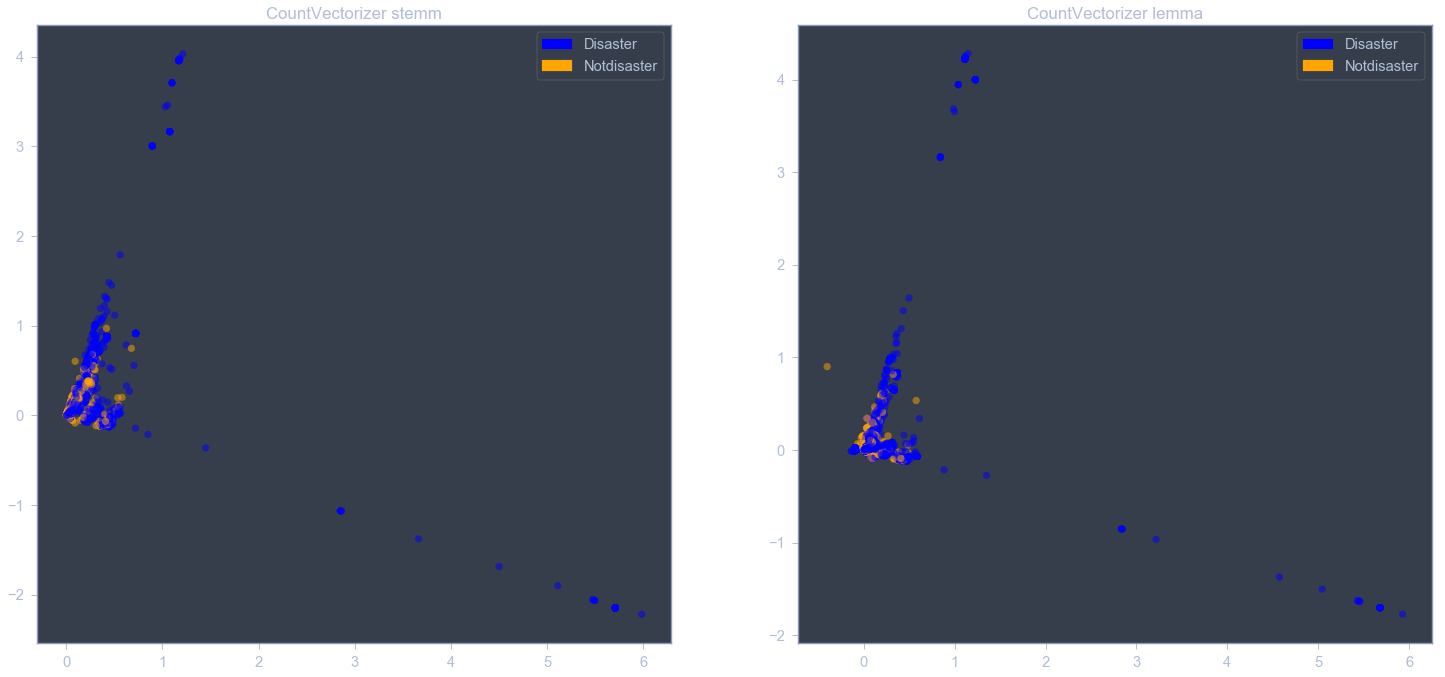

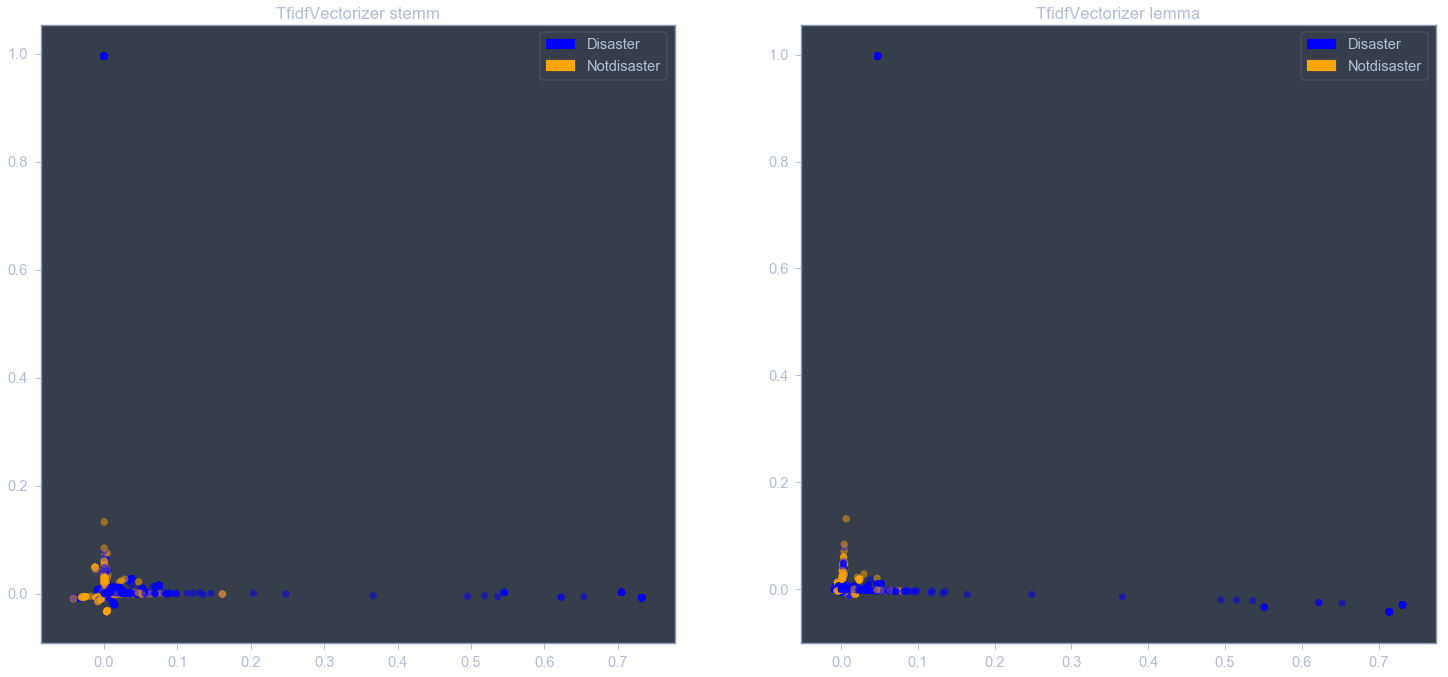

In [44]:
colors = ['orange', 'blue']
i = 0
for vect_type, vect_name in zip((count_vect, tfidf_vect),
                                ('CountVectorizer', 'TfidfVectorizer')):
    plt.figure(figsize = (25, 25))
    for text_prep in ('stemm', 'lemma'):
        plt.subplot(2, 2, i + 1)
        train_text = vect_type.fit_transform(data_train[text_prep])
        train_pca = pca.fit_transform(train_text)
        plt.scatter(train_pca[:, 0], train_pca[:, 1], alpha = 0.5, 
                    c = target, cmap = ListedColormap(colors))
        plt.title(vect_name + ' ' + text_prep)
        dis = mpatches.Patch(color = 'blue', label = 'Disaster')
        notdis = mpatches.Patch(color = 'orange', label = 'Notdisaster')
        plt.legend(handles = [dis, notdis])
        i += 1
        
    plt.show()

# Final datasets

Сформируем итоговые датасеты

In [45]:
all_text = tfidf_vect.fit_transform(all_data['lemma'])
train = all_text[:len(data_train)]
test = all_text[len(data_train):]

In [46]:
print 'train shape', train.shape
print 'test shape', test.shape

train shape (7613, 135400)
test shape (3263, 135400)


# Tune models

Матрица признаков в задачах NLP, как правило, сильно разрежена и имеет большую размерность, поэтому в таких задачах преимущественно применяются линейные модели

Попробуем следующие модели 
 - Logistic regression
 - SVC (с различными ядрами)

Используем StratifiedKFold на 5 фолдов

In [47]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Tune logistic regression

In [48]:
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)

params_grid = {
              'penalty' : ['l1', 'l2']
}

grid_cv = GridSearchCV(logreg, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'penalty': 'l2'}
F1_score on CV: 0.6555135512331866


In [49]:
logreg = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 42)

params_grid = {
              'C' : np.arange(1, 20, 0.5)
}

grid_cv = GridSearchCV(logreg, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'C': 16.5}
F1_score on CV: 0.7303450469123486


In [50]:
logreg = LogisticRegression(C = 16.5, penalty = 'l2', solver = 'liblinear', random_state = 42)
logreg.fit(train, target)
print 'F1_score on train data', metrics.f1_score(target, logreg.predict(train))

F1_score on train data 0.9818069688559976


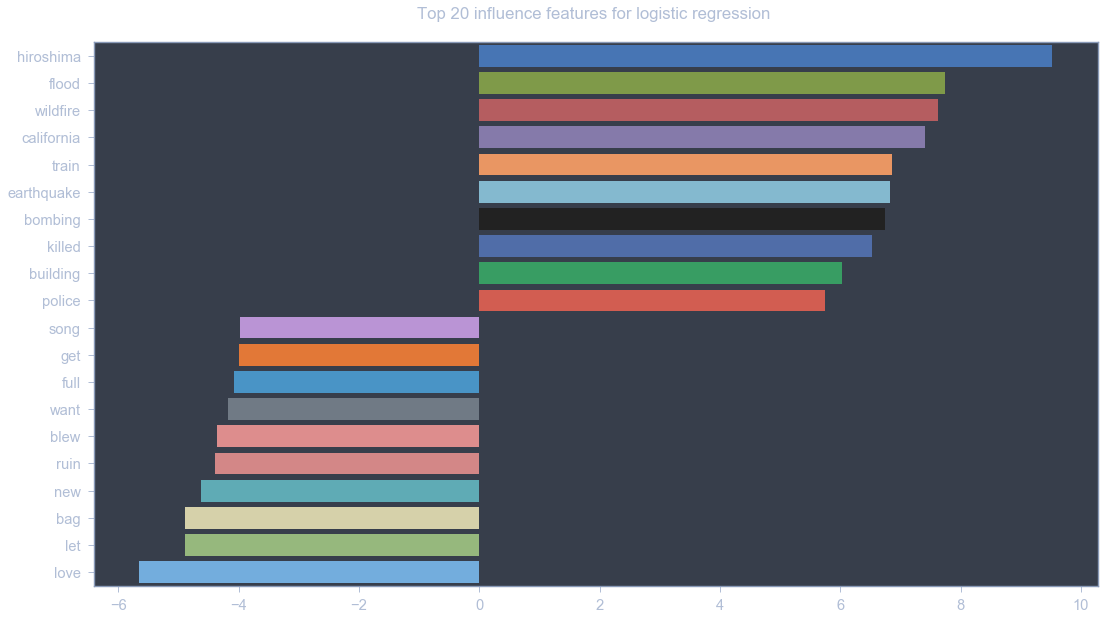

In [51]:
argmax = np.ravel(np.argsort(logreg.coef_))[-10:][: : -1]
argmin = np.ravel(np.argsort(logreg.coef_))[:10]

importances, features = (list(x) for x in zip(*sorted(zip(np.ravel(logreg.coef_)[np.hstack((argmax, argmin))], \
                                                          np.ravel(tfidf_vect.get_feature_names())[np.hstack((argmax, argmin))]), \
                                                          reverse = True)))
plt.figure(figsize = (18, 10))
sns.barplot(importances, features)
plt.title('Top 20 influence features for logistic regression \n')
plt.show()

# Tune SVC (kernel = linear)

In [52]:
svc = SVC(kernel = 'linear', random_state = 42)

params_grid = {
              'C' : np.arange(1, 14, 1),
}

grid_cv = GridSearchCV(svc, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'C': 2}
F1_score on CV: 0.7414117668893354


In [53]:
svc = SVC(C = 2, kernel = 'linear', random_state = 42)
svc.fit(train, target)
print 'F1_score on train data', metrics.f1_score(target, svc.predict(train))

F1_score on train data 0.9776269094275574


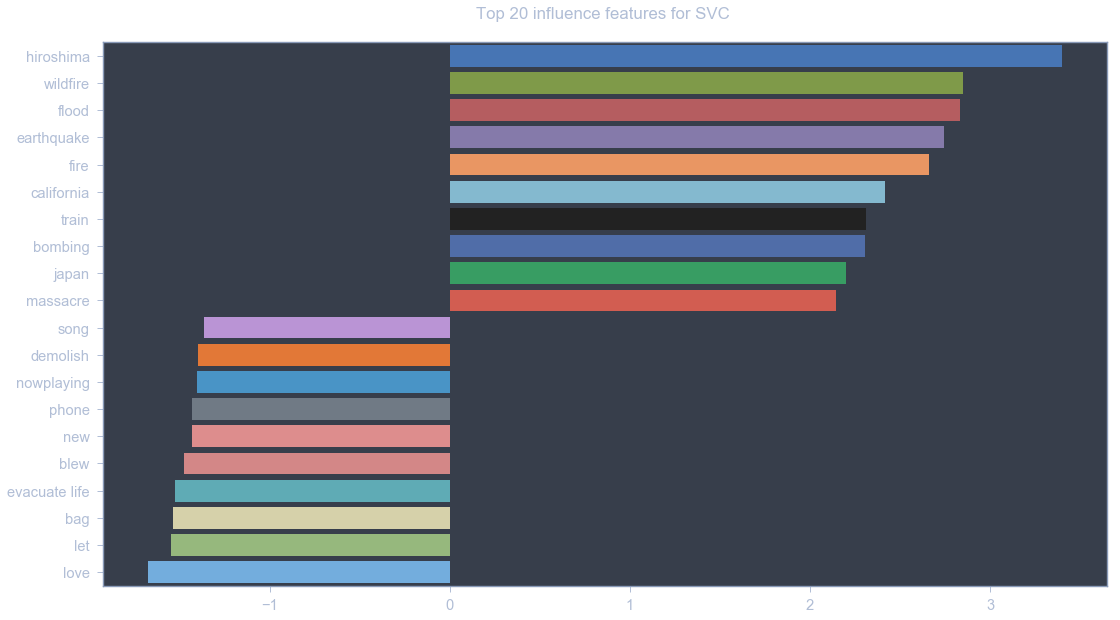

In [54]:
argmax = np.argsort(np.ravel((svc.coef_).toarray()))[-10:][: : -1]
argmin = np.argsort(np.ravel((svc.coef_).toarray()))[:10]

importances, features = (list(x) for x in zip(*sorted(zip(np.ravel((svc.coef_).toarray())[np.hstack((argmax, argmin))], \
                                                          np.ravel(tfidf_vect.get_feature_names())[np.hstack((argmax, argmin))]), \
                                                          reverse = True)))
plt.figure(figsize = (18, 10))
sns.barplot(importances, features)
plt.title('Top 20 influence features for SVC \n')
plt.show()

# Tune SVC (kernel = rbf)

In [55]:
svc_rbf = SVC(kernel = 'rbf', random_state = 42)

params_grid = {
              'C' : np.arange(1, 13, 1),
              'gamma' : np.arange(0.1, 1, 0.2)
}

grid_cv = GridSearchCV(svc_rbf, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'C': 10, 'gamma': 0.1}
F1_score on CV: 0.7410193122406332


In [56]:
svc_rbf = SVC(C = 10, gamma = 0.1, kernel = 'rbf', random_state = 42)
svc_rbf.fit(train, target)
print 'F1_score on train data', metrics.f1_score(target, svc_rbf.predict(train))

F1_score on train data 0.9774760876272756


# Tune LinearSVC

Разница между LinearSVC и SVC(kernel = linear):

 - SVC(kernel = linear) минимизирует hinge loss: $L=sum(max((1 - M), 0)$

 - LinearSVC минимизирует (по умолчанию) squared hinge loss: $L=sum(max((1 - M), 0)^2$

Поэтому LinearSVC сильнее штрафует алгоритм за неверную классификацию, но меньше штрафует за неуверенный ответ алгоритма

In [57]:
linear_svc = LinearSVC(random_state = 42)

params_grid = {
              'C' : np.arange(1, 13, 0.2),
}

grid_cv = GridSearchCV(linear_svc, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'C': 4.3999999999999995}
F1_score on CV: 0.7353019200806021


In [58]:
linear_svc = LinearSVC(random_state = 42)

params_grid = {
              'C' : np.arange(4, 5, 0.1),
}

grid_cv = GridSearchCV(linear_svc, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'C': 4.6999999999999975}
F1_score on CV: 0.7353961359383763


In [59]:
linear_svc = LinearSVC(C = 4.69, random_state = 42)
linear_svc.fit(train, target)
print 'F1_score on train data:', metrics.f1_score(target, linear_svc.predict(train))

F1_score on train data: 0.982899399168079


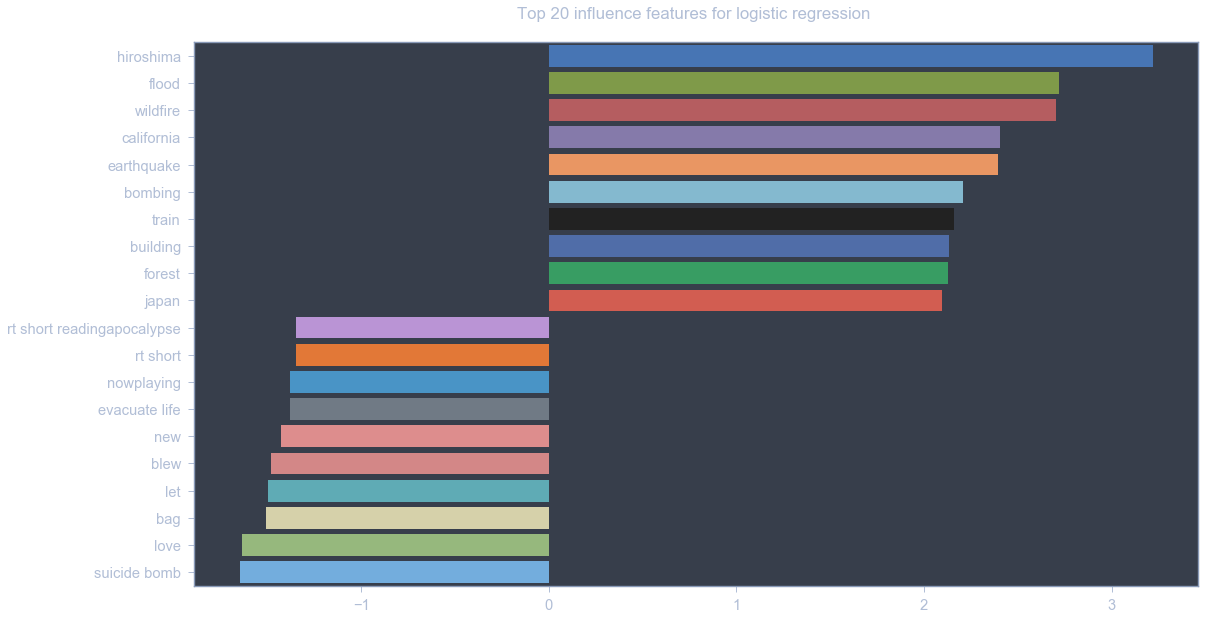

In [60]:
argmax = np.argsort(np.ravel((linear_svc.coef_)))[-10:][: : -1]
argmin = np.argsort(np.ravel((linear_svc.coef_)))[:10]

importances, features = (list(x) for x in zip(*sorted(zip(np.ravel(linear_svc.coef_)[np.hstack((argmax, argmin))], \
                                                          np.ravel(tfidf_vect.get_feature_names())[np.hstack((argmax, argmin))]), \
                                                          reverse = True)))
plt.figure(figsize = (18, 10))
sns.barplot(importances, features)
plt.title('Top 20 influence features for logistic regression \n')
plt.show()

# Voting Classifier

In [61]:
from sklearn.ensemble import VotingClassifier

In [62]:
vot_class = VotingClassifier(estimators = [('svc', svc), ('svc_rbf', svc_rbf), 
                                           ('linear_svc', linear_svc)])

params_grid = {
              'voting' : ['hard']
}

grid_cv = GridSearchCV(vot_class, params_grid, cv = kf, scoring = 'f1')
grid_cv.fit(train, target)
print grid_cv.best_params_
print 'F1_score on CV:', grid_cv.best_score_

{'voting': 'hard'}
F1_score on CV: 0.7418152588379539


In [63]:
#voting classifier
vot_class = VotingClassifier(estimators = [('svc', svc), ('svc_rbf', svc_rbf),
                                           ('linear_svc', linear_svc)])

#fit vot_class
vot_class.fit(train, target)

VotingClassifier(estimators=[('svc', SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)), ('svc_rbf', SVC(C=10, cache_size=200, class... max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

# Predict submission

In [64]:
submission = vot_class.predict(test).astype('int64')

In [65]:
answer = pd.DataFrame({'target' : submission}, index = data_test['id'])
answer.head(5)

,target
id,
0,1
2,1
3,1
9,1
11,1


In [66]:
answer.to_csv('Kaggle disaster tweets.csv')